## Calculate skill of a MJO Index of S2S models as function of daily lead time

In [1]:
# linting
%load_ext nb_black
%load_ext lab_black

<IPython.core.display.Javascript object>

In [2]:
import xarray as xr

xr.set_options(display_style="html")

import numpy as np
import matplotlib.pyplot as plt
from climpred import HindcastEnsemble
import climpred

<IPython.core.display.Javascript object>

IRIDL hosts various subseasonal initialized forecast and hindcast simulations:

- `S2S project`:
    - http://iridl.ldeo.columbia.edu/SOURCES/.ECMWF/.S2S/
        - hindcast/reforecast: one variable, one model: ~ 80 GB
        - login required
- `SubX project`:
    - http://iridl.ldeo.columbia.edu/SOURCES/.Models/.SubX/
        - hindcast/reforecast: one variable, one model: ~ 100 GB
        - login not required

---

Here, we demonstrate how to set a cookie for IRIDL and access the skill of RMM1 subseasonal reforecasts.

---

Here are instructions for configuring xarray to open protected Data Library datasets, after you have created a Data Library account and accepted the terms and conditions for the dataset.
1. Visit https://iridl.ldeo.columbia.edu/auth/genkey . Log in to the Data Library. Copy the key from the response.

2. Create a file with the following content, substituting the key from step 1 for `"xxxx"`:
`Set-Cookie: __dlauth_id=xxxx; domain=.iridl.ldeo.columbia.edu`

3. Put the following in `~/.daprc`, which is `/home/jovyan/.daprc` on renku, substituting the path to the above file for `/path/to/cookie/file`:
`HTTP.COOKIEJAR=/path/to/cookie/file`. You may need to copy `.daprc` to `/home/jovyan` on renku, because `/home/jovyan` is not tracked by `git`.

In [3]:
!cat ~/.daprc

HTTP.COOKIEJAR=/Users/aaron.spring/.cookie_iridl


<IPython.core.display.Javascript object>

In [4]:
#%writefile ~/.cookie_iridl
# Set-Cookie: __dlauth_id=xxxx; domain=.iridl.ldeo.columbia.edu

<IPython.core.display.Javascript object>

### Get observations

In [5]:
# pre-computed
obsds = climpred.tutorial.load_dataset("RMM-INTERANN-OBS")[
    "rmm1"
].to_dataset()  # only until 2017
obsds = obsds.dropna("time").sel(time=slice("1995", None))  # Get rid of missing times.

<IPython.core.display.Javascript object>

### Get `on-the-fly` reforecasts

S2S models:

- `ECMF`
- `ECCC`
- `HMCR`
- `KMA`
- `UKMO`

There are a set of reforecasts of the ECMWF model that match each real time forecast. They are made "on the fly" when a real time forecast is issued. So for S=0000 8 Feb 2021, there are reforecasts initialized on 0000 8 Feb 2020 and the 19 previous years on 8 Feb.

In [13]:
%%time 
fcstds = xr.open_dataset(
    "https://iridl.ldeo.columbia.edu/SOURCES/.ECMWF/.S2S/.ECMF/.reforecast/.RMMS/.ensembles/.RMM1/dods",
    decode_times=False,
    chunks=None,
).compute()

CPU times: user 613 ms, sys: 1.06 s, total: 1.67 s
Wall time: 24.6 s


<IPython.core.display.Javascript object>

In [14]:
# calendar '360' not recognized, but '360_day'
if fcstds.hdate.attrs["calendar"] == "360":
    fcstds.hdate.attrs["calendar"] = "360_day"

<IPython.core.display.Javascript object>

The S2S data dimensions correspond to the following `climpred` dimension definitions: `M=member`, `S=init`.  We will rename the dimensions to their `climpred` names.

In [15]:
# rename to match climpred dims: https://climpred.readthedocs.io/en/stable/setting-up-data.html
fcstds = fcstds.rename({"S": "init", "L": "lead", "M": "member", "RMM1": "rmm1"})

<IPython.core.display.Javascript object>

In [16]:
fcstds = xr.decode_cf(fcstds, use_cftime=True)
fcstds.coords

Coordinates:
  * hdate    (hdate) object 1995-07-01 00:00:00 ... 2020-07-01 00:00:00
  * init     (init) object 2015-05-14 00:00:00 ... 2021-02-15 00:00:00
  * member   (member) float32 0.0 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0
  * lead     (lead) timedelta64[ns] 1 days 2 days 3 days ... 45 days 46 days

<IPython.core.display.Javascript object>

#### Skill for a single real-time forecast from corresponding reforecasts

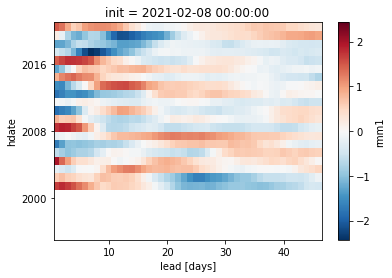

<IPython.core.display.Javascript object>

In [20]:
# assessing the skill of the reforecasts done annually from 8 Feb 2001 to 8 Feb 2020
# for the real-time forecast 8 Feb 2021
d = "08"
m = "02"
y = "2021"

fcstds.sel(init=f"{y}-{m}-{d}").squeeze().rmm1.mean("member").plot()

In [21]:
import cftime

# create a new init coordinate
new_init = xr.concat(
    [
        xr.DataArray(
            cftime.DatetimeProlepticGregorian(int(h.dt.year.values), int(m), int(d))
        )
        for h in fcstds.hdate
    ],
    "init",
)

# select new inits for same dayofyear, drop all NaNs
fcstds_date = (
    fcstds.sel(init=f"{y}-{m}-{d}", drop=True)
    .squeeze(drop=True)
    .assign_coords(hdate=new_init)
    .rename({"hdate": "init"})
    .dropna("init", how="all")
)

<IPython.core.display.Javascript object>

In [23]:
hindcast = HindcastEnsemble(fcstds_date)
hindcast = hindcast.add_observations(obsds)

<IPython.core.display.Javascript object>

In [24]:
%time skill = hindcast.verify(metric='acc', comparison='e2o', dim='init', alignment='maximize')

CPU times: user 1.8 s, sys: 24.5 ms, total: 1.82 s
Wall time: 1.99 s


<IPython.core.display.Javascript object>

Text(0.5, 1.0, 'ACC: RMM1 daily initialized 02-08')

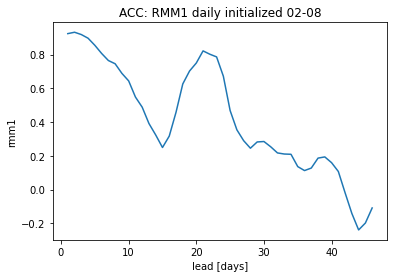

<IPython.core.display.Javascript object>

In [25]:
skill.rmm1.plot()
plt.title(f"ACC: RMM1 daily initialized {m}-{d}")

#### skill over many initializations
create large `xr.DataArray` with all `hdate` stacked into `init`

In [26]:
# restricting myself to years 2001-2003 for faster computation
fcstds = fcstds.sel(hdate=slice("2001", "2003"))
obs_ds = obsds.sel(time=slice("2001", "2004"))

<IPython.core.display.Javascript object>

In [27]:
%%time
fcstds_dates = []
# loop over all inits, ignoring leap day
for s in fcstds.init:
    d = str(s.init.dt.day.values).zfill(2)
    m = str(s.init.dt.month.values).zfill(2)
    y = s.init.dt.year.values
    if d == "29" and m == "02":
        continue
    new_init = xr.concat(
        [
            xr.DataArray(
                cftime.DatetimeProlepticGregorian(int(h.dt.year.values), int(m), int(d))
            )
            for h in fcstds.hdate
        ],
        "init",
    )
    # select new inits for same dayofyear, drop all NaNs
    fcstds_date = (
        fcstds.sel(init=f"{y}-{m}-{d}", drop=True)
        .squeeze(drop=True)
        .assign_coords(hdate=new_init)
        .rename({"hdate": "init"})
        .dropna("init", how="all")
    )
    if fcstds_date.init.size > 0:  # not empty
        fcstds_dates.append(fcstds_date)

fcstds_dates = xr.concat(fcstds_dates, "init")

fcstds_dates = fcstds_dates.sortby(fcstds_dates.init)

CPU times: user 17.4 s, sys: 243 ms, total: 17.7 s
Wall time: 19.7 s


<IPython.core.display.Javascript object>

In [29]:
hindcast = HindcastEnsemble(fcstds_dates)
hindcast = hindcast.add_observations(obs_ds)

<IPython.core.display.Javascript object>

CPU times: user 55.2 s, sys: 576 ms, total: 55.7 s
Wall time: 1min 1s


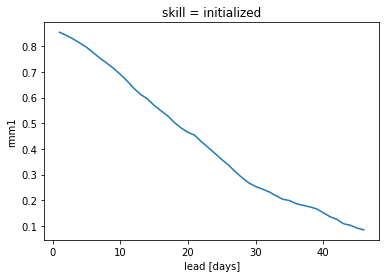

<IPython.core.display.Javascript object>

In [30]:
%time skill_all = hindcast.verify(metric='acc', comparison='e2o', dim='init', alignment='maximize')

skill_all.rmm1.plot()

#### skill when initialized in different months

In [31]:
import warnings

warnings.filterwarnings(
    "ignore"
)  # ignore climpred UserWarnings triggered by verification.sel(init)

<IPython.core.display.Javascript object>

CPU times: user 11.1 s, sys: 124 ms, total: 11.2 s
Wall time: 12.4 s


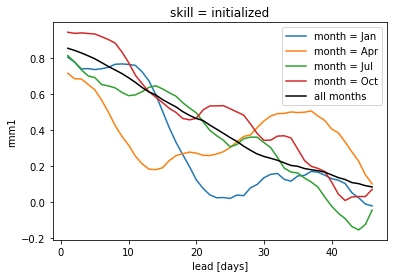

<IPython.core.display.Javascript object>

In [32]:
%%time
for m in np.arange(1, 13, 3):
    hindcast_month = hindcast.sel(init=fcstds_dates.init.dt.month == m)
    month_name = hindcast_month.get_initialized().init[:2].to_index().strftime("%b")[0]
    skill = (
        hindcast_month.verify(metric="acc", comparison="e2o", dim="init", alignment="maximize")
    )
    skill.rmm1.plot(label=f"month = {month_name}")
skill_all.rmm1.plot(label='all months',c='k')
plt.legend()

### Get reforecasts without `on-the-fly`
very similar workflow as in the `SubX` examples as there is no `hdate` coordinate: [subseasonal SubX examples](examples.html#subseasonal)

S2S models:

- `CRNM`
- `CMA`
- `BOM`
- `ISAC`
- `JMA`
- `NCEP`

In [33]:
%%time
fcstds = xr.open_dataset(
    "https://iridl.ldeo.columbia.edu/SOURCES/.ECMWF/.S2S/.CNRM/.reforecast/.RMMS/.ensembles/.RMM1/dods",
    decode_times=True,
).compute()

fcstds = fcstds.dropna("S", how="all")

CPU times: user 454 ms, sys: 804 ms, total: 1.26 s
Wall time: 21.2 s


<IPython.core.display.Javascript object>

In [34]:
# rename to match climpred dims: https://climpred.readthedocs.io/en/stable/setting-up-data.html
fcstds = fcstds.rename({"S": "init", "L": "lead", "M": "member", "RMM1": "rmm1"})

<IPython.core.display.Javascript object>

In [35]:
hindcast = HindcastEnsemble(fcstds)
hindcast = hindcast.add_observations(obsds)

<IPython.core.display.Javascript object>

In [36]:
%time skill = hindcast.verify(metric='acc', comparison='e2o', dim='init', alignment='maximize')

CPU times: user 54.3 s, sys: 688 ms, total: 55 s
Wall time: 1min 6s


<IPython.core.display.Javascript object>

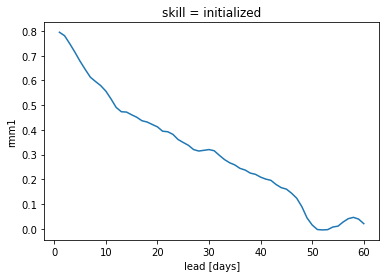

<IPython.core.display.Javascript object>

In [37]:
skill.rmm1.plot()